---

## 11.5 Beyond text classification: Sequence-to-sequence learning

TensorFlow [tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

In [1]:
import  sys, os
import re, string, random, pathlib
import numpy as np

from IPython.display import YouTubeVideo

import tensorflow as tf

In [2]:
# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/6-additional-material')      # 'My Drive' is the default name of Google Drives,
    os.listdir() 

### 11.5.1 A machine translation example

The attention mechanism originated in research in sequence to sequence with RNNs. The idea was to improve the hidden state of the generating RNN by allowing it to access (pay attention to) various parts of the source sequence at each step of the generation. Later on, the move was to remove the RNN mechanism altogether, and only use attention in both encoder and decoder.

<!-- <img style="height:700px" src="images/nlp/stanford.seq2seq.png"> -->
<img style="height:700px" src="https://drive.google.com/uc?id=1_cSV5Qy1Ln_l75VhlOVialvNAX5zMu2Q">

<small>[Chris Manning, CS224N, Stanford](https://web.stanford.edu/class/cs224n/index.html), [lecture 7](https://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture07-nmt.pdf)  
The original paper: ["Sequence to Sequence Learning with Neural Networks"](https://arxiv.org/abs/1409.3215)</small>

<!-- <img src="images/nlp/seq2seq-nmt-model-fast.gif"> -->
<img src="https://drive.google.com/uc?id=11kGWdBJgrVbGGkXTMjAe74A5kZuNkpiP">

<small>[Google seq2seq documentation](https://google.github.io/seq2seq/)</small>


### The Transformer: who *needs* RNNs anyway??

<!-- <img src="images/transformer/apply_the_transformer_to_machine_translation.gif"> -->
<img src="https://drive.google.com/uc?id=1oEGwdJPUFs7P1A5eE7Aow_A3RBt3kvIe">

<small>["Neural machine translation with a Transformer and Keras", TensorFlow](https://www.tensorflow.org/text/tutorials/transformer)  
The paper: [Vaswani et al, "Attention Is All You Need"](https://arxiv.org/abs/1706.03762)</small>

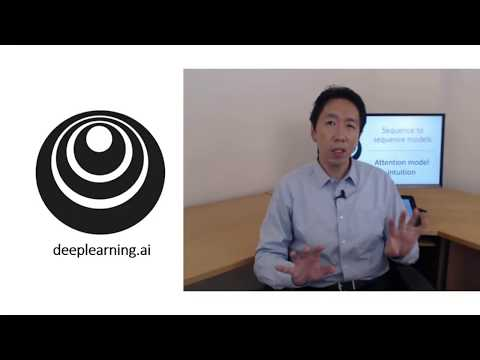

In [2]:
YouTubeVideo('SysgYptB198', width=853, height=480, start=2592) # C5W3L07 Attention Model Intuition 

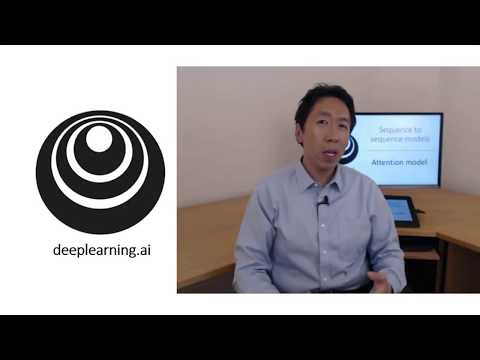

In [3]:
YouTubeVideo('quoGRI-1l0A', width=853, height=480, start=2592) # C5W3L08 Attention Model  

### The Transformer applied to translation


<!-- <img src="images/transformer/apply_the_transformer_to_machine_translation.gif"> -->
<img src="https://drive.google.com/uc?id=1oEGwdJPUFs7P1A5eE7Aow_A3RBt3kvIe">

<small>["Neural machine translation with a Transformer and Keras", TensorFlow](https://www.tensorflow.org/text/tutorials/transformer)</small>

### Download the dataset

```bash
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip
```

Other languages available [here](https://www.manythings.org/anki/)! 

In [3]:
base_dir = pathlib.Path("spa-eng")
text_file = base_dir / "spa.txt"
 
with open(text_file) as f:
    lines = f.read().strip().split("\n")

text_pairs = []
separator = "\t" if "\t" in lines[0] else " " # spa.txt is tab separated, but the other datasets use spaces

for i, line in enumerate(lines):
    print(f"line: {i}/{len(lines)}\r", end="")
    english, spanish = line.split(separator)[:2] # for datasets other than the official one, only tak
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [4]:
print(random.choice(text_pairs))

('It took them some time to get used to each other.', '[start] Les tomó algo de tiempo acostumbrarse el uno al otro. [end]')


In [5]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

#### Vectorizing the English and Spanish text pairs

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

#### Preparing datasets for the translation task

In [28]:
batch_size = 64 # my 6GB GPU can go up to 1560

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [29]:
for inputs, targets in train_ds:
    print(f"inputs['english'].shape: {inputs['english'].shape}, dtype: {inputs['english'].dtype}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}, dtype: {inputs['spanish'].dtype}")
    print(f"targets.shape: {targets.shape}, dtype: {targets.dtype}")
    break

inputs['english'].shape: (64, 20), dtype: <dtype: 'int64'>
inputs['spanish'].shape: (64, 20), dtype: <dtype: 'int64'>
targets.shape: (64, 20), dtype: <dtype: 'int64'>


2022-11-22 16:03:32.221087: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


---

### 11.5.2 Sequence-to-sequence learning with RNNs

#### GRU-based encoder

In [9]:
embed_dim = 256
latent_dim = 1024

source = tf.keras.Input(shape=(None,), dtype="int64", name="english")
x = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(latent_dim), merge_mode="sum"
)(x)

#### GRU-based decoder and the end-to-end model

In [10]:
past_target = tf.keras.Input(shape=(None,), dtype="int64", name="spanish")
x = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = tf.keras.layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = tf.keras.layers.Dropout(0.5)(x)
target_next_step = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = tf.keras.Model([source, past_target], target_next_step)

#### Training our recurrent sequence-to-sequence model

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history = seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15


2022-11-01 16:13:41.924830: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_41/output/_17'


1302/1302 [==============================] - 192s 125ms/step - loss: 1.6352 - accuracy: 0.4178 - val_loss: 1.3110 - val_accuracy: 0.5056
Epoch 2/15
1302/1302 [==============================] - 157s 121ms/step - loss: 1.3122 - accuracy: 0.5282 - val_loss: 1.1527 - val_accuracy: 0.5678
Epoch 3/15
1302/1302 [==============================] - 159s 122ms/step - loss: 1.1724 - accuracy: 0.5772 - val_loss: 1.0746 - val_accuracy: 0.5993
Epoch 4/15
1302/1302 [==============================] - 157s 120ms/step - loss: 1.0812 - accuracy: 0.6089 - val_loss: 1.0401 - val_accuracy: 0.6174
Epoch 5/15
1302/1302 [==============================] - 157s 121ms/step - loss: 1.0361 - accuracy: 0.6331 - val_loss: 1.0252 - val_accuracy: 0.6281
Epoch 6/15
1302/1302 [==============================] - 158s 121ms/step - loss: 1.0069 - accuracy: 0.6507 - val_loss: 1.0211 - val_accuracy: 0.6322
Epoch 7/15
1302/1302 [==============================] - 158s 121ms/step - loss: 0.9873 - accuracy: 0.6643 - val_loss: 1.020

The [issue (warning)](https://github.com/keras-team/keras/issues/16978) doesn't seem to be resolved yet...

#### Translating new sentences with our RNN encoder and decoder

In [31]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence], verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [30]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20
test_eng_texts = [pair[0] for pair in test_pairs]

In [ ]:
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
It's up to you to decide.
[start] es usted a [UNK] [end]
-
The jury has returned a verdict of guilty.
[start] el [UNK] ha sido un [UNK] de lo que y el [UNK] [end]
-
Tom is devious, isn't he?
[start] tom es [UNK] verdad [end]
-
I don't know her real name.
[start] no sé su nombre de su nombre [end]
-
He shook hands with his friend.
[start] Él [UNK] las manos con su amigo [end]
-
She is a wealthy woman.
[start] ella es una mujer mujer [end]
-
Could you hand me the newspaper on the table?
[start] me puedes el libro sobre la mesa [end]
-
The train leaves at six.
[start] el tren las seis en punto [end]
-
Come again tomorrow.
[start] ven mañana [end]
-
I tried to talk a friend of mine out of getting married.
[start] intentó un amigo de las cosas que tom [end]
-
Can you see the difference?
[start] puedes ver la guitarra [end]
-
Anybody home?
[start] alguien está en casa [end]
-
Tom described how he was able to escape from the locked room.
[start] tom sabía que él fue capaz de ver la habitaci

---

### 11.5.3 Sequence-to-sequence learning with Transformer

#### Putting it all together: A Transformer for machine translation

<!-- <img style="" src="images/transformer/the-annotated-transformer_14_0.transformer-full.png"> -->
<img src="https://drive.google.com/uc?id=1q24jSyMvzKI160pR6VDmY30i7ulwHKIK">


<small>[Vaswani et al, "Attention Is All You Need"](https://arxiv.org/abs/1706.03762)</small>

#### The Transformer encoder

In [12]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                               # parameters
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(     # multi-head attention layer
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(                   # dense layer on top: like a nonlinearity
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()  # layer norm
        self.layernorm_2 = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:                                     # optional mask
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask                  # only two inputs! Value is used as key as well
        )
        proj_input = self.layernorm_1(inputs + attention_output) # inputs + attn: residual connection
        proj_output = self.dense_proj(proj_input)                # dense layer on top: like a nonlinearity
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

#### The Transformer decoder

In [13]:
def get_causal_attention_mask(inputs):
    print("Inputs:")
    print(inputs)
    print()
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    print(f"i:\n{i}")
    print()
    print(f"j:\n{j}")
    print()
    mask = tf.cast(i >= j, dtype="int32")
    print("Is i >= i? Boolean cast to ints. (Note the broadcasting)")
    print()
    print(mask)
    print()
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1])) # adding a batch dimension
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1),
         tf.constant([1, 1], dtype=tf.int32)], axis=0)
    print("We want mask to have the same dims as input, using `tf.tile`.")
    print("Creating the right multiplier for it:")
    print()
    print(mult)
    print()
    tile = tf.tile(mask, mult)
    print("Final mask with batch dimensions:")
    print()
    print(tile)
    return tile

mask = get_causal_attention_mask(tf.random.uniform(shape=(2,10), maxval=50, dtype=tf.int32))

Inputs:
tf.Tensor(
[[34 40 43 44  3 24 32 24 48  5]
 [11 19 46 14 26 19 43  6 44 11]], shape=(2, 10), dtype=int32)

i:
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]

j:
[0 1 2 3 4 5 6 7 8 9]

Is i >= i? Boolean cast to ints. (Note the broadcasting)

tf.Tensor(
[[1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]], shape=(10, 10), dtype=int32)

We want mask to have the same dims as input, using `tf.tile`.
Creating the right multiplier for it:

tf.Tensor([2 1 1], shape=(3,), dtype=int32)

Final mask with batch dimensions:

tf.Tensor(
[[[1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0 0 0]
  [1 1 1 1 0 0 0 0 0 0]
  [1 1 1 1 1 0 0 0 0 0]
  [1 1 1 1 1 1 0 0 0 0]
  [1 1 1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 1 1 0 0]
  [1 1 1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1 1 1]]

 [[1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0

In [14]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                              # parameters
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = tf.keras.layers.MultiHeadAttention(  # multi-head attention
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(                  # dense layer on top: like a nonlinearity
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization() # layer norm
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True                            # MASK: enforcing causality

    # retrieve config as a dict (necessary for custom Keras layers)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        
        causal_mask = self.get_causal_attention_mask(inputs)               # prepare the causal mask
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
            
        attention_output_1 = self.attention_1(                             # REGULAR MASKED ATTENTION
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)                                    # first layer: apply the causal mask
        attention_output_1 = self.layernorm_1(inputs + attention_output_1) # layer norm
        
        attention_output_2 = self.attention_2(                             # CROSS-ATTENTION
            query=attention_output_1,                                      # query: output of DECODER
            value=encoder_outputs,                                         # key:   output of ENCODER
            key=encoder_outputs,                                           # value: output of ENCODER
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(                             # layer norm: concatenate both attention matrices
            attention_output_1 + attention_output_2)                       # cross-attention (encoder) + regular masked attention (decoder)
        
        proj_output = self.dense_proj(attention_output_2)                  # dense net / nonlinearity
        return self.layernorm_3(attention_output_2 + proj_output)

#### PositionalEmbedding layer

In [15]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
         
        self.token_embeddings = tf.keras.layers.Embedding(       # token embeddings: semantic information
            input_dim=input_dim, output_dim=output_dim
        )
        self.position_embeddings = tf.keras.layers.Embedding(    # position embeddings: syntactic/spatial information
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length                   # more params
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        embedded_tokens = self.token_embeddings(inputs)          # 1. create token embeddings
                                                                 # 2. create pos embeddings
        positions = tf.range(start=0, limit=length, delta=1)     #    (as many as our input length, delta: step size)
        embedded_positions = self.position_embeddings(positions)
        
        return embedded_tokens + embedded_positions              # 3. Both embeddings are simply added together!

    def compute_mask(self, inputs, mask=None):                   # Turns int sequences into a mask, example:
        return tf.math.not_equal(inputs, 0)                      # [ 12   3    54   3    0     0     ]
                                                                 # [ True True True True False False ]

    def get_config(self):                                        # retrieve config as a dict
        config = super().get_config()                            # (required for Keras layers)
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### End-to-end Transformer

In [16]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

#### Training the sequence-to-sequence Transformer

In [17]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['english[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 positional_embedding_1 (Positi  (None, None, 256)   3845120     ['spanish[0][0]']          

In [24]:
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
54/54 [==============================] - 65s 1s/step - loss: 1.5495 - accuracy: 0.4139 - val_loss: 1.3521 - val_accuracy: 0.4445
Epoch 2/30
54/54 [==============================] - 60s 1s/step - loss: 1.3139 - accuracy: 0.4766 - val_loss: 1.1480 - val_accuracy: 0.5164
Epoch 3/30
54/54 [==============================] - 60s 1s/step - loss: 1.1538 - accuracy: 0.5275 - val_loss: 1.0796 - val_accuracy: 0.5381
Epoch 4/30
54/54 [==============================] - 60s 1s/step - loss: 1.0309 - accuracy: 0.5706 - val_loss: 0.9525 - val_accuracy: 0.5922
Epoch 5/30
54/54 [==============================] - 60s 1s/step - loss: 0.9187 - accuracy: 0.6093 - val_loss: 0.8776 - val_accuracy: 0.6191
Epoch 6/30
54/54 [==============================] - 60s 1s/step - loss: 0.8293 - accuracy: 0.6414 - val_loss: 0.8200 - val_accuracy: 0.6437
Epoch 7/30
54/54 [==============================] - 60s 1s/step - loss: 0.7553 - accuracy: 0.6669 - val_loss: 0.7993 - val_accuracy: 0.6439
Epoch 8/30
54/54 [==

#### Translating new sentences with our Transformer model

In [33]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [34]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20
test_eng_texts = [pair[0] for pair in test_pairs]

In [36]:
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
How is it that you can speak this language?
[start] cómo es que hablar en este idioma [end]
-
I just want to take a quick look.
[start] solo quiero tomar una mirada [end]
-
You should read more.
[start] deberías leer más [end]
-
Have you been told when to come?
[start] te has dicho cuándo venga [end]
-
Are you for or against the war?
[start] estás a favor o en la guerra [end]
-
You do not realize how important health is until you get sick.
[start] no te das cuenta de lo que es importante que te das enfermo [end]
-
Crossing that desert is dangerous.
[start] la gente que es peligroso el mundo sabe peligroso [end]
-
Do people ever accuse you of being snobbish?
[start] la gente de la gente se hace a la gente que te [UNK] [end]
-
Tom tried to rescue Mary.
[start] tom intentó salvar a mary [end]
-
I'll always remember you.
[start] siempre te amaré [end]
-
I grabbed my little sister's hand and started running.
[start] cogí mi hermana pequeña hermana y salió a correr [end]
-
Tom told us all 

## Summary

## References

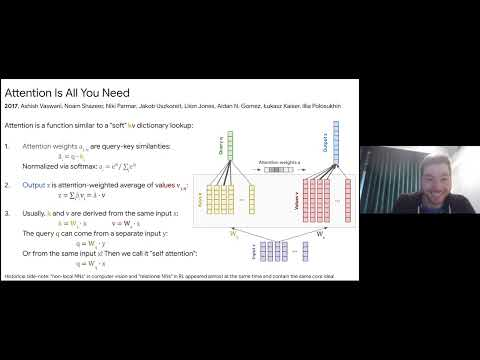

In [2]:
YouTubeVideo('EixI6t5oif0', width=853, height=480) # Transformers with Lucas Beyer, Google Brain 

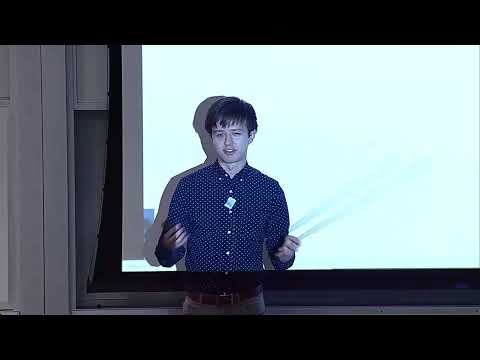

In [3]:
YouTubeVideo('ptuGllU5SQQ', width=853, height=480) # Stanford CS224N NLP with Deep Learning | Winter 2021 | Lecture 9 - Self- Attention and Transformers 

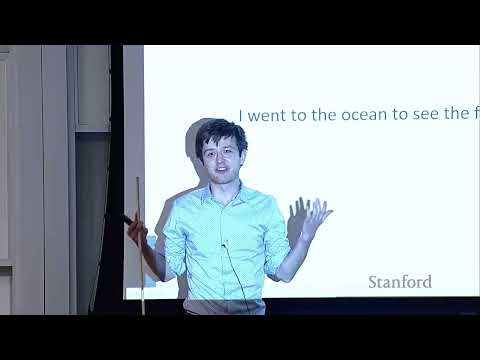

In [7]:
YouTubeVideo('j9AcEI98C0o', width=853, height=480) # Stanford CS224N NLP with Deep Learning | Winter 2021 | Lecture 10 - Transformers and Pretraining 

### Transformers from scratch

[Blog post](https://peterbloem.nl/blog/transformers).

Videos:

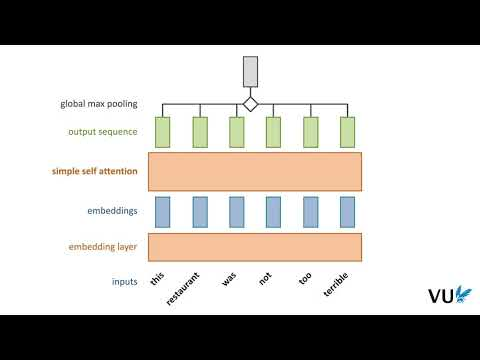

In [5]:
YouTubeVideo('KmAISyVvE1Y', width=853, height=480) #  Lecture 12.1 Self-attention
# The whole playlist: https://www.youtube.com/watch?v=KmAISyVvE1Y&list=PLIXJ-Sacf8u60G1TwcznBmK6rEL3gmZmV

### More

An [entire YouTube playlist](https://www.youtube.com/playlist?list=PLoROMvodv4rNiJRchCzutFw5ItR_Z27CM) covering various research topics & transformers.